In [37]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import copy
import enum
import codecs
import math
import datetime
from pathlib import Path
import os
from matplotlib.collections import LineCollection
import numpy as np
from abc import ABCMeta
from abc import abstractmethod
%matplotlib ipympl

In [38]:
class PlotObject(metaclass = ABCMeta):
    @abstractmethod
    def draw(self):
        return NotImplementedError

In [39]:
class Canvas(PlotObject):
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []  
        self.debug = debug
        self.time_span = time_span  
        self.time_interval = time_interval 
        
    def append(self,obj):  
        self.objects.append(obj)
    
    def draw(self): 
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')             
        ax.set_xlim(-10,10)                  
        ax.set_ylim(-10,10) 
        ax.set_xlabel("X",fontsize=10)                 
        ax.set_ylabel("Y",fontsize=10)                 
        
        elems = []
        
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()
        
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        time_str = "[%dst generation]" % (i)
        elems.append(ax.text(-9.0, 11.0, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)

In [40]:
class City(PlotObject):
    def __init__(self, x, y):
        self.pos = np.array([x,y]).T
        self.id = None
    
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="cities", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], str(self.id), fontsize=10))

In [41]:
class Map(PlotObject):
    def __init__(self, num_of_cities):
        self.cities = []
        self.num_of_cities = num_of_cities
    
    def append_city(self, city):
        city.id = len(self.cities)
        self.cities.append(city)
    
    def generate_map(self, seed=100):
        np.random.seed(seed=seed)
        for _ in range(self.num_of_cities):
            self.append_city(City(np.random.rand()*20 - 10, np.random.rand()*20 - 10))

    def draw(self, ax, elems):
        for c in self.cities : c.draw(ax, elems)

In [42]:
class Agent(PlotObject):
    def __init__(self, map, start_id = 0):
        self.map = map
        self.start_point_id = start_id
        self.start_city_pos = [city.pos for city in self.map.cities if city.id == self.start_point_id][0]
        self.root_list = np.array([e.id for e in self.map.cities if e.id != self.start_point_id])
        self.distance = 0.0

    def optimize_root(self):
        print("Agent class's method called", self.root_list)
    
    def get_norm(self,x,y):
        return np.linalg.norm(x-y)
    
    def calculate_distance(self, root_list):
        distance = 0.0
        distance += self.get_norm(self.start_city_pos, self.map.cities[root_list[0]].pos)
        for i in range(0, len(root_list)-1):
            distance += self.get_norm(self.map.cities[root_list[i]].pos, self.map.cities[root_list[i+1]].pos)
        distance += self.get_norm(self.map.cities[root_list[i+1]].pos, self.start_city_pos)
        return distance
    
    def draw(self, ax, elems):

        ## draw the calculated root
        lines = [] 
        lines.append([self.start_city_pos, self.map.cities[self.root_list[0]].pos])
        for i in range(0, len(self.root_list)-1):
            lines.append([self.map.cities[self.root_list[i]].pos, self.map.cities[self.root_list[i+1]].pos])
        lines.append([self.map.cities[self.root_list[i+1]].pos, self.start_city_pos])

        lc = LineCollection(lines)
        elems.append(ax.add_collection(lc))
        elems.append(ax.text(-1.0, 11.0, "the minimize distance:%.2f" % (self.distance), fontsize=10))
    
    def one_step(self, time_interval):
        self.optimize_root()
        self.distance = self.calculate_distance(self.root_list)


In [43]:
class Individual:
    def __init__(self, id, codes, point):
        self.id = id
        self.codes = codes
        self.point = point

In [44]:
class Generation:
    def __init__(self, individuals):
        self.individuals = individuals
        self.weights = []
        self.normalized_weights = None
        self._set_weights()
        self._set_normalized_weights()
    
    def _set_weights(self):
        if (len(self.individuals) > 0):
            data = []
            for e in self.individuals:
                data.append(e.point)
            _data = np.array(data).astype(float)
            min_num = np.min(_data)
            var = np.var(_data)
            for e in self.individuals:
                self.weights.append(1/math.sqrt(2*math.pi*var + 0.01)*math.exp(-(e.point - min_num)**2 / (2*var + 0.01)))

    
    def _set_normalized_weights(self):
        if (len(self.weights) > 0):
            self.normalized_weights = np.array(self.weights)/np.sum(self.weights)

    def best_individual(self):
        weights = np.array(self.weights)
        max_index = np.argmax(weights)
        return self.individuals[max_index]
    
    def append_individuals(self, individual):
        self.individuals.append(individual)
    
    def get_length_of_individuals(self):
        return len(self.individuals)
    
    def get_individuals_as_ndarray(self):
        return np.array(self.individuals)
    
    def clear_individuals(self):
        self.individuals.clear()
    
    def set_weights(self):
        self._set_weights()
        self._set_normalized_weights()

In [45]:
@enum.unique
class Operation(enum.Enum):
    cross = "cross"
    mutation = "mutation"
    reproduction = "reproduction"

In [46]:
class GaAgent(Agent):
    def __init__(self, map, start_id = 0, num_of_individuals=25, cross_prob=0.90, mutate_prob=0.05, save_dir = "./scores/"):
        super().__init__(map, start_id=start_id)
        self.num_of_individuals = num_of_individuals
        self.cross_prob = cross_prob
        self.mutate_prob = mutate_prob
        self.buffa = None
        self.generation_count = 0
        self.best_score_plot = []
        self.save_dir = save_dir
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        self.save_file_name = "score_" + datetime.datetime.now().isoformat() + ".csv"
        self.save_path = os.path.join(self.save_dir, self.save_file_name)
        print("the best scores below", file=codecs.open(self.save_path,"w","utf-8"))

    def _create_generation(self):
        individuals = []
        for i in range(self.num_of_individuals):
            codes = np.random.choice(self.root_list, size=len(self.root_list),replace=False)
            weight = self.calculate_distance(codes)
            individual = Individual(id=f"No{self.generation_count:03}-{i:05}", codes=codes, point=weight)
            individuals.append(individual)
        ge = Generation(individuals=individuals)
        self.generation_count += 1
        return ge

    def _crossing(self, one, other, try_replace=3):
        one = copy.deepcopy(one)
        other = copy.deepcopy(other)
        for _ in range(try_replace):
            one_index1, one_index2 = np.random.choice(np.arange(len(one.codes)), size=2, replace=False)
            other_index1 = np.where(other.codes==one.codes[one_index1])[0][0]
            other_index2 = np.where(other.codes==one.codes[one_index2])[0][0]
            if ((one_index1 - one_index2)*(other_index1 - other_index2) < 0):
                one.codes[one_index1], one.codes[one_index2] = one.codes[one_index2], one.codes[one_index1]
                other.codes[other_index1], other.codes[other_index2] = other.codes[other_index2], other.codes[other_index1]
        return (one, other)
    
    def _mutation(self, individual):
        one = copy.deepcopy(individual)
        former, latter = np.random.choice([i for i in range(len(one.codes))], 2, replace=False)
        one.codes[former], one.codes[latter] = one.codes[latter], one.codes[former]
        return one

    def _reproduction(self, individual):
        return copy.deepcopy(individual)

    # @override
    def optimize_root(self):
        if self.buffa == None:
            print("start")
            now_ge = self._create_generation()
        else:
            print("next")
            now_ge = Generation(individuals=self.buffa.individuals)
            print(len(now_ge.individuals), len(now_ge.normalized_weights))
        next_ge = Generation([])
        while len(next_ge.individuals) < self.num_of_individuals:
            operation = np.random.choice([Operation.cross, Operation.mutation, Operation.reproduction], 1, p=[self.cross_prob, self.mutate_prob, 1-self.cross_prob-self.mutate_prob])[0]
            # print(operation)
            if operation == Operation.cross:
                one, other = np.random.choice(now_ge.individuals, size=2, p=now_ge.normalized_weights, replace=False)
                new_one, new_other = self._crossing(one, other)
                new_one.point = self.calculate_distance(new_one.codes)
                new_other.point = self.calculate_distance(new_other.codes)
                next_ge.append_individuals(new_one)
                next_ge.append_individuals(new_other)

            elif operation == Operation.mutation:
                one = np.random.choice(now_ge.individuals, size=1, p=now_ge.normalized_weights)[0]
                new_one = self._mutation(one)
                new_one.point = self.calculate_distance(new_one.codes)
                next_ge.append_individuals(new_one)

            elif operation == Operation.reproduction:
                one = np.random.choice(now_ge.individuals, size=1, p=now_ge.normalized_weights)[0]
                new_one = self._reproduction(one)
                new_one.point = self.calculate_distance(new_one.codes)
                next_ge.append_individuals(new_one)
            else:
                one = np.random.choice(now_ge.individuals, size=1, p=now_ge.normalized_weights)[0]
                new_one = self._reproduction(one)
                new_one.point = self.calculate_distance(new_one.codes)
                next_ge.append_individuals(new_one)
        
        next_ge.set_weights()
        self.root_list = next_ge.best_individual().codes
        print("best root is ", self.root_list)
        print("best score is ", next_ge.best_individual().point)
        score = next_ge.best_individual().point
        print(score, file=codecs.open(self.save_path,"a","utf-8"))
        self.buffa = next_ge

    # def one_step(self, time_interval):
    #     self.optimize_root()
    #     self.distance = self.calculate_distance(self.root_list)

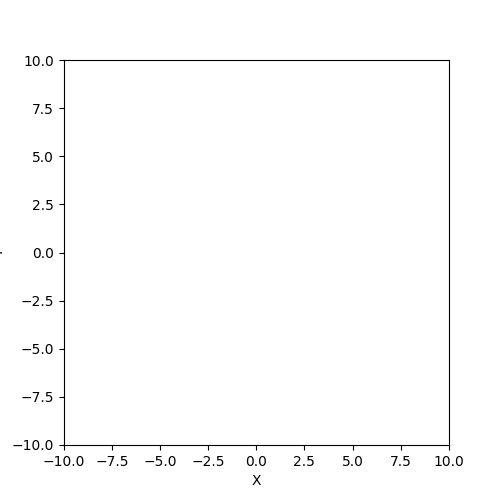

next
25 25
best root is  [18  3 17  2 13  6 16  4 12  7 11  1 10 15  8  5 19 14  9]
best score is  168.16810249380293
next
25 25
best root is  [18  3 17  2 13  6 16  4 12  7 11  1 10 15  8  5 19 14  9]
best score is  168.16810249380293
next
25 25
best root is  [18  3 17  2 13  6 16  4 12  7 10  1  8 15 11  5 19 14  9]
best score is  158.17338584227213
next
25 25
best root is  [18  3 17  2 13  6 16  4 12  7 15  1 10 11  8  5 19 14  9]
best score is  154.84855905748893
next
25 25
best root is  [18  3 17  2 13  6 16  4 12  7 15  1 10 11  8  5 19 14  9]
best score is  154.84855905748893
next
26 26
best root is  [18  3 17  2 13  6 16  4 12  7 15  1 10 11  8  5 19 14  9]
best score is  154.84855905748893
next
25 25
best root is  [18  3 17  2 13  6 16  4 12  7 15  1 10 11  8  5 19 14  9]
best score is  154.84855905748893
next
26 26
best root is  [18  3 17  2 13  6 16  4 12  7 15  1 10 11  8  5 19 14  9]
best score is  154.84855905748893
next
26 26
best root is  [18  3 17  2 13  6 16  4 12  7 

In [47]:
def main():
    dt = 1.5
    num_of_cities = 20
    generation_steps = 50 * dt

    canvas = Canvas(generation_steps, dt)
    m = Map(num_of_cities)
    m.generate_map()
    
    canvas.append(m)
    agent = GaAgent(m)

    canvas.append(agent)
    
    canvas.draw()

if __name__ == "__main__":
    main()

In [48]:
# def my_callback(i, elems, ax):
#     while elems: elems.pop().remove()
#     print(i)
#     time_str = "hoge %.2f" % (i*0.1)
#     elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))


# def main():
#     fig = plt.figure(figsize=(4,4))
#     ax = fig.add_subplot(111)
#     ax.set_aspect('equal')             
#     ax.set_xlim(-5,5)                  
#     ax.set_ylim(-5,5) 
#     ax.set_xlabel("X",fontsize=10)                 
#     ax.set_ylabel("Y",fontsize=10)                 
    
#     elems = []
    
#     ani = anm.FuncAnimation(fig, my_callback, fargs=(elems, ax), frames=int(100), interval=int(100), repeat=False)
#     ani.save("./sample.gif", writer="imagemagick")
#     plt.show()
    